### Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
!pip install dmba
from dmba import classificationSummary, gainsChart, liftChart
from sklearn.ensemble import RandomForestClassifier

     |████████████████████████████████| 11.8MB 234kB/s 
no display found. Using non-interactive Agg backend


### Open Files, Create DataFrames, Zero Null Values
#### *To keep nulls, comment 3rd var, remove "n" from dataframe var.

In [2]:
url = 'https://raw.githubusercontent.com/vikivayner/Data-Challenge-Team-14/main/test.csv'
test = pd.read_csv(url)
tsn = pd.DataFrame(test)
ts = tsn.fillna(0)

url2 = 'https://raw.githubusercontent.com/vikivayner/Data-Challenge-Team-14/main/train.csv'

train = pd.read_csv(url2)
trn = pd.DataFrame(train)
tr = trn.fillna(0)

### Convert "LastRecord" and "Date Deployed" to Datetime

In [3]:
ts["LastRecord"], ts["Date Deployed"] = pd.to_datetime(ts["LastRecord"]), pd.to_datetime(ts["Date Deployed"])
tr["LastRecord"], tr["Date Deployed"] = pd.to_datetime(tr["LastRecord"]), pd.to_datetime(tr["Date Deployed"])

### Create "DaysInService" Column, Convert from TimeDelta to Float for Plotting

In [4]:
ts["DaysInService"] = ts["LastRecord"] - ts["Date Deployed"]
ts["DaysInService"] = ts["DaysInService"].dt.days.astype("float64")
tr["DaysInService"] = tr["LastRecord"] - tr["Date Deployed"]
tr["DaysInService"] = tr["DaysInService"].dt.days.astype("float64")

### Get Info and Head (Raw Df)

In [5]:
#ts.info()
#ts.head()

tr.info()
tr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40500 entries, 0 to 40499
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   deviceid                     40500 non-null  int64         
 1   avg_time_charging_lag1       40500 non-null  float64       
 2   avg_time_charging_lag2       40500 non-null  float64       
 3   avg_time_charging_lag3       40500 non-null  float64       
 4   avg_time_charging_lag7       40500 non-null  float64       
 5   charging_rate_lag3           40500 non-null  float64       
 6   charging_rate_lag7           40500 non-null  float64       
 7   avg_time_discharging_lag1    40500 non-null  float64       
 8   avg_time_discharging_lag2    40500 non-null  float64       
 9   avg_time_discharging_lag3    40500 non-null  float64       
 10  avg_time_discharging_lag7    40500 non-null  float64       
 11  discharging_rate_lag3        40500 non-nu

,deviceid,avg_time_charging_lag1,avg_time_charging_lag2,avg_time_charging_lag3,avg_time_charging_lag7,charging_rate_lag3,charging_rate_lag7,avg_time_discharging_lag1,avg_time_discharging_lag2,avg_time_discharging_lag3,avg_time_discharging_lag7,discharging_rate_lag3,discharging_rate_lag7,fail_7,charge_cycle_time_below_12,avg_time_charging_lag4,avg_time_discharging_lag4,avg_time_charging_lag5,avg_time_discharging_lag5,avg_time_charging_lag6,avg_time_discharging_lag6,avg_time_charging_lag8,avg_time_discharging_lag8,avg_time_charging_lag9,avg_time_discharging_lag9,avg_time_charging_lag10,avg_time_discharging_lag10,avg_time_charging_lag11,avg_time_discharging_lag11,avg_time_charging_lag12,avg_time_discharging_lag12,avg_time_charging_lag13,avg_time_discharging_lag13,avg_time_charging_lag14,avg_time_discharging_lag14,discharging_rate_lag4,discharging_rate_lag5,discharging_rate_lag6,discharging_rate_lag8,charging_rate_lag4,charging_rate_lag5,charging_rate_lag6,chargecycles,dischargecycles,total_off_time,number_times_restart,avg_volt_change_charging,avg_volt_change_discharging,avg_time_charging,avg_time_discharging,max_voltage_day,piececount,cycle_time,LastRecord,Date Deployed,DaysInService
0,28647,5.12,41.11,6.56,25.39,0.086667,-0.006667,4.37,91.70,15.70,39.12,-1.163333,0.033333,0,False,4.99,5.85,24.35,31.02,43.42,79.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.360000,1.573333,0.816667,-0.173333,-0.070000,-1.603333,-0.166667,50.250000,49.750000,49.000000,2.375000,377.080000,367.428750,21.696250,39.005000,4174.875000,14.200000,60.701250,2021-04-01,2019-10-06,543.0
1,36175,36.60,5.16,6.23,6.96,0.136667,-1.296667,62.67,6.53,6.16,8.25,-0.066667,-2.653333,0,False,13.64,20.37,5.65,4.77,19.41,24.33,35.92,59.38,4.49,4.12,44.18,72.46,27.45,49.02,10.89,18.93,21.39,35.90,0.00,0.00,-4.593333,0.450000,-3.063333,-0.103333,0.216667,0.000000,-1.010000,56.285714,56.000000,36.857143,1.000000,350.517857,350.309286,19.883571,32.213571,4161.000000,19.777778,52.097143,2021-04-01,2019-10-27,522.0
2,16107,5.51,5.04,4.52,5.96,-0.460000,-0.083333,5.13,5.65,4.14,14.02,-2.643333,0.686667,0,False,25.01,40.69,6.03,6.06,5.72,5.73,22.46,31.82,33.92,58.87,45.87,76.36,5.78,6.23,5.13,4.37,4.73,3.50,26.79,41.29,-0.050000,0.240000,0.000000,0.216667,-0.026667,0.000000,-0.013333,80.380952,80.333333,2.333333,4.095238,346.113333,343.409524,13.675238,20.471429,4152.238095,19.200000,34.146667,2021-04-01,2019-10-31,518.0
3,27362,4.66,39.85,35.76,40.69,0.076667,-0.006667,3.93,76.37,60.86,73.53,-0.166667,0.033333,0,False,4.71,3.74,4.74,3.73,24.01,52.99,5.09,5.32,4.45,4.22,22.14,30.51,4.39,4.15,4.71,3.82,13.27,18.62,4.97,4.16,0.013333,0.406667,-0.293333,-0.046667,-0.030000,0.460000,1.340000,91.736842,91.684211,10.789474,0.736842,356.184211,349.844737,16.306842,26.189474,4164.631579,23.625000,42.496316,2021-04-01,2019-10-01,548.0
4,19463,5.10,43.24,4.63,5.26,0.040000,-0.153333,4.69,71.44,3.80,6.29,0.066667,-1.030000,0,True,40.36,82.70,15.47,24.21,45.64,76.42,26.63,45.04,27.99,40.57,5.01,6.52,5.47,4.64,5.28,5.16,25.10,47.76,21.62,37.29,-0.353333,0.983333,-0.006667,-1.790000,0.016667,1.606667,0.013333,71.066667,70.733333,14.266667,1.133333,370.904000,367.730000,18.797333,30.812000,4169.800000,12.666667,49.609333,2021-04-01,2019-09-13,566.0


### Count Null Values
#### *Keep nulls above to observe progressive linearity.

In [6]:
#ts.isnull().sum()
#tr.isnull().sum()

### Plot Distributions of DataFrame Columns
#### *no plot for "deviceid" (irrelevant) or "charge_cycle_time_below_12" (bool)
#### **uncomment to run

In [7]:
"""
for col in ts.columns[1:]:
    if col != "charge_cycle_time_below_12":
        hist = ts[col].hist(bins=10)
        print("Plot for column \"{}\"".format(col))
        plt.show()
"""

"""
for col in tr.columns[1:]:
    if col != "charge_cycle_time_below_12":
        hist = tr[col].hist(bins=10)
        print("Plot for column \"{}\"".format(col))
        plt.show()
"""

'\nfor col in tr.columns[1:]:\n    if col != "charge_cycle_time_below_12":\n        hist = tr[col].hist(bins=10)\n        print("Plot for column "{}"".format(col))\n        plt.show()\n'

### Create New DataFrame, Removing Columns Without Outliers

In [8]:
columns = [column for column in ts.columns if ts[column].dtype == "float64"]
tsno = ts[columns]

columns = [column for column in tr.columns if tr[column].dtype == "float64"]
trno = tr[columns]

### Convert Outliers by Quantile to Null in New DataFrame.

In [9]:
q_low = tsno[columns].quantile(0.01)
q_hi  = tsno[columns].quantile(0.99)

ts0 = tsno[(tsno[columns] < q_hi) & (tsno[columns] > q_low)]

#ts0.info()
#ts0.head()

q_low = trno[columns].quantile(0.01)
q_hi  = trno[columns].quantile(0.99)

tr0 = trno[(trno[columns] < q_hi) & (trno[columns] > q_low)]

#tr0.info()
#tr0.head()

### Count New OUTLIER Null Values

In [10]:
#ts0.isnull().sum()
#tr0.isnull().sum()

### Plot New DataFrame Outlier Nulls

In [11]:
"""
for col in ts0.columns:
    hist = ts0[col].hist(bins=100)
    print("Plot for column \"{}\"".format(col))
    plt.show()
"""

"""
for col in tr0.columns:
    hist = tr0[col].hist(bins=100)
    print("Plot for column \"{}\"".format(col))
    plt.show()
"""

'\nfor col in tr0.columns:\n    hist = tr0[col].hist(bins=100)\n    print("Plot for column "{}"".format(col))\n    plt.show()\n'

### Rebuild DataFrames WITH Outlier Nulls for Feature Importance
#### *Adding ints, bools, and datetimes from original df.  Uncomment to zero nulls.

In [12]:
tso = ts[["deviceid", "charge_cycle_time_below_12", "LastRecord", "Date Deployed"]]
frames = [tso, ts0]
ts1 = pd.concat(frames, axis=1)
#ts1 = ts1.fillna(0)

#ts1.info()
#ts1.info()

tro = tr[["deviceid", "fail_7", "charge_cycle_time_below_12", "LastRecord", "Date Deployed"]]
frames = [tr0, tro]
tr1 = pd.concat(frames, axis=1)
#tr1 = tr1.fillna(0)

tr1.info()
tr1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40500 entries, 0 to 40499
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   avg_time_charging_lag1       39679 non-null  float64       
 1   avg_time_charging_lag2       39660 non-null  float64       
 2   avg_time_charging_lag3       39610 non-null  float64       
 3   avg_time_charging_lag7       39647 non-null  float64       
 4   charging_rate_lag3           39688 non-null  float64       
 5   charging_rate_lag7           39689 non-null  float64       
 6   avg_time_discharging_lag1    39673 non-null  float64       
 7   avg_time_discharging_lag2    39676 non-null  float64       
 8   avg_time_discharging_lag3    39678 non-null  float64       
 9   avg_time_discharging_lag7    39684 non-null  float64       
 10  discharging_rate_lag3        39690 non-null  float64       
 11  discharging_rate_lag7        39690 non-nu

,avg_time_charging_lag1,avg_time_charging_lag2,avg_time_charging_lag3,avg_time_charging_lag7,charging_rate_lag3,charging_rate_lag7,avg_time_discharging_lag1,avg_time_discharging_lag2,avg_time_discharging_lag3,avg_time_discharging_lag7,discharging_rate_lag3,discharging_rate_lag7,avg_time_charging_lag4,avg_time_discharging_lag4,avg_time_charging_lag5,avg_time_discharging_lag5,avg_time_charging_lag6,avg_time_discharging_lag6,avg_time_charging_lag8,avg_time_discharging_lag8,avg_time_charging_lag9,avg_time_discharging_lag9,avg_time_charging_lag10,avg_time_discharging_lag10,avg_time_charging_lag11,avg_time_discharging_lag11,avg_time_charging_lag12,avg_time_discharging_lag12,avg_time_charging_lag13,avg_time_discharging_lag13,avg_time_charging_lag14,avg_time_discharging_lag14,discharging_rate_lag4,discharging_rate_lag5,discharging_rate_lag6,discharging_rate_lag8,charging_rate_lag4,charging_rate_lag5,charging_rate_lag6,chargecycles,dischargecycles,total_off_time,number_times_restart,avg_volt_change_charging,avg_volt_change_discharging,avg_time_charging,avg_time_discharging,max_voltage_day,piececount,cycle_time,DaysInService,deviceid,fail_7,charge_cycle_time_below_12,LastRecord,Date Deployed
0,5.12,41.11,6.56,25.39,0.086667,-0.006667,4.37,91.70,15.70,39.12,-1.163333,0.033333,4.99,5.85,24.35,31.02,43.42,79.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.360000,1.573333,0.816667,-0.173333,-0.070000,-1.603333,-0.166667,50.250000,49.750000,49.000000,2.375000,377.080000,367.428750,21.696250,39.005000,4174.875000,14.200000,60.701250,543.0,28647,0,False,2021-04-01,2019-10-06
1,36.60,5.16,6.23,6.96,0.136667,-1.296667,62.67,6.53,6.16,8.25,-0.066667,-2.653333,13.64,20.37,5.65,4.77,19.41,24.33,35.92,59.38,4.49,4.12,44.18,72.46,27.45,49.02,10.89,18.93,21.39,35.90,NaN,NaN,-4.593333,0.450000,-3.063333,-0.103333,0.216667,0.000000,-1.010000,56.285714,56.000000,36.857143,1.000000,350.517857,350.309286,19.883571,32.213571,4161.000000,19.777778,52.097143,522.0,36175,0,False,2021-04-01,2019-10-27
2,5.51,5.04,4.52,5.96,-0.460000,-0.083333,5.13,5.65,4.14,14.02,-2.643333,0.686667,25.01,40.69,6.03,6.06,5.72,5.73,22.46,31.82,33.92,58.87,45.87,76.36,5.78,6.23,5.13,4.37,4.73,3.50,26.79,41.29,-0.050000,0.240000,0.000000,0.216667,-0.026667,0.000000,-0.013333,80.380952,80.333333,2.333333,4.095238,346.113333,343.409524,13.675238,20.471429,4152.238095,19.200000,34.146667,518.0,16107,0,False,2021-04-01,2019-10-31
3,4.66,39.85,35.76,40.69,0.076667,-0.006667,3.93,76.37,60.86,73.53,-0.166667,0.033333,4.71,3.74,4.74,3.73,24.01,52.99,5.09,5.32,4.45,4.22,22.14,30.51,4.39,4.15,4.71,3.82,13.27,18.62,4.97,4.16,0.013333,0.406667,-0.293333,-0.046667,-0.030000,0.460000,1.340000,91.736842,91.684211,10.789474,0.736842,356.184211,349.844737,16.306842,26.189474,4164.631579,23.625000,42.496316,548.0,27362,0,False,2021-04-01,2019-10-01
4,5.10,43.24,4.63,5.26,0.040000,-0.153333,4.69,71.44,3.80,6.29,0.066667,-1.030000,40.36,82.70,15.47,24.21,45.64,76.42,26.63,45.04,27.99,40.57,5.01,6.52,5.47,4.64,5.28,5.16,25.10,47.76,21.62,37.29,-0.353333,0.983333,-0.006667,-1.790000,0.016667,1.606667,0.013333,71.066667,70.733333,14.266667,1.133333,370.904000,367.730000,18.797333,30.812000,4169.800000,12.666667,49.609333,566.0,19463,0,True,2021-04-01,2019-09-13


## Dummy Coding

In [13]:
tr1.dtypes

avg_time_charging_lag1                float64
avg_time_charging_lag2                float64
avg_time_charging_lag3                float64
avg_time_charging_lag7                float64
charging_rate_lag3                    float64
charging_rate_lag7                    float64
avg_time_discharging_lag1             float64
avg_time_discharging_lag2             float64
avg_time_discharging_lag3             float64
avg_time_discharging_lag7             float64
discharging_rate_lag3                 float64
discharging_rate_lag7                 float64
avg_time_charging_lag4                float64
avg_time_discharging_lag4             float64
avg_time_charging_lag5                float64
avg_time_discharging_lag5             float64
avg_time_charging_lag6                float64
avg_time_discharging_lag6             float64
avg_time_charging_lag8                float64
avg_time_discharging_lag8             float64
avg_time_charging_lag9                float64
avg_time_discharging_lag9         

In [14]:
tr1 = pd.get_dummies(tr,drop_first=True,prefix_sep='_') 
tr1.columns

Index(['deviceid', 'avg_time_charging_lag1', 'avg_time_charging_lag2',
       'avg_time_charging_lag3', 'avg_time_charging_lag7',
       'charging_rate_lag3', 'charging_rate_lag7', 'avg_time_discharging_lag1',
       'avg_time_discharging_lag2', 'avg_time_discharging_lag3',
       'avg_time_discharging_lag7', 'discharging_rate_lag3',
       'discharging_rate_lag7', 'fail_7', 'charge_cycle_time_below_12',
       'avg_time_charging_lag4', 'avg_time_discharging_lag4',
       'avg_time_charging_lag5', 'avg_time_discharging_lag5',
       'avg_time_charging_lag6', 'avg_time_discharging_lag6',
       'avg_time_charging_lag8', 'avg_time_discharging_lag8',
       'avg_time_charging_lag9', 'avg_time_discharging_lag9',
       'avg_time_charging_lag10', 'avg_time_discharging_lag10',
       'avg_time_charging_lag11', 'avg_time_discharging_lag11',
       'avg_time_charging_lag12', 'avg_time_discharging_lag12',
       'avg_time_charging_lag13', 'avg_time_discharging_lag13',
       'avg_time_charging_

In [15]:
predictors = ['avg_time_charging_lag1', 'avg_time_charging_lag2',
       'avg_time_charging_lag3', 'avg_time_charging_lag7',
       'charging_rate_lag3', 'charging_rate_lag7', 'avg_time_discharging_lag1',
       'avg_time_discharging_lag2', 'avg_time_discharging_lag3',
       'avg_time_discharging_lag7', 'discharging_rate_lag3',
       'discharging_rate_lag7', 'charge_cycle_time_below_12',
       'avg_time_charging_lag4', 'avg_time_discharging_lag4',
       'avg_time_charging_lag5', 'avg_time_discharging_lag5',
       'avg_time_charging_lag6', 'avg_time_discharging_lag6',
       'avg_time_charging_lag8', 'avg_time_discharging_lag8',
       'avg_time_charging_lag9', 'avg_time_discharging_lag9',
       'avg_time_charging_lag10', 'avg_time_discharging_lag10',
       'avg_time_charging_lag11', 'avg_time_discharging_lag11',
       'avg_time_charging_lag12', 'avg_time_discharging_lag12',
       'avg_time_charging_lag13', 'avg_time_discharging_lag13',
       'avg_time_charging_lag14', 'avg_time_discharging_lag14',
       'discharging_rate_lag4', 'discharging_rate_lag5',
       'discharging_rate_lag6', 'discharging_rate_lag8', 'charging_rate_lag4',
       'charging_rate_lag5', 'charging_rate_lag6', 'chargecycles',
       'dischargecycles', 'total_off_time', 'number_times_restart',
       'avg_volt_change_charging', 'avg_volt_change_discharging',
       'avg_time_charging', 'avg_time_discharging', 'max_voltage_day',
       'piececount', 'cycle_time',
       'DaysInService']
outcome = 'fail_7'

In [16]:
X = tr1[predictors]
y = tr1[outcome]
X.shape

(40500, 52)

In [17]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=1)

## Logistic Regression

In [18]:
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear',class_weight = 'balanced')
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1e+42, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns))

                                coeff
avg_time_charging_lag1       0.014018
avg_time_charging_lag2       0.012708
avg_time_charging_lag3       0.008388
avg_time_charging_lag7       0.016211
charging_rate_lag3           0.065039
charging_rate_lag7          -0.019600
avg_time_discharging_lag1   -0.007825
avg_time_discharging_lag2   -0.006459
avg_time_discharging_lag3   -0.003772
avg_time_discharging_lag7   -0.007735
discharging_rate_lag3        0.094688
discharging_rate_lag7       -0.004363
charge_cycle_time_below_12   1.679705
avg_time_charging_lag4       0.004803
avg_time_discharging_lag4   -0.001204
avg_time_charging_lag5       0.009172
avg_time_discharging_lag5   -0.003508
avg_time_charging_lag6       0.013555
avg_time_discharging_lag6   -0.006306
avg_time_charging_lag8       0.009965
avg_time_discharging_lag8   -0.004074
avg_time_charging_lag9       0.007931
avg_time_discharging_lag9   -0.003721
avg_time_charging_lag10      0.008072
avg_time_discharging_lag10  -0.002896
avg_time_cha

charge_cycle_time_below_12 is the most important feature in this model. avg_time_charging and avg_time_discharging are the next most important features.

### Model Metrics

In [20]:
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.6140)

       Prediction
Actual     0     1
     0 12120  9642
     1  1302  5286
Confusion Matrix (Accuracy 0.6071)

       Prediction
Actual    0    1
     0 5125 4212
     1  562 2251


In [21]:
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score,roc_auc_score,classification_report, confusion_matrix
lr_prediction_train = logit_reg.predict_proba(train_X)[:,1] > 0.5
lr_prediction_valid = logit_reg.predict_proba(valid_X)[:,1] > 0.5
print("Accuracy on train is:",accuracy_score(train_y,lr_prediction_train))
print("Accuracy on test is:",accuracy_score(valid_y,lr_prediction_valid))
print("Precision_score train is:",precision_score(train_y,lr_prediction_train))
print("Precision_score on test is:",precision_score(valid_y,lr_prediction_valid))
print("Recall_score on train is:",recall_score(train_y,lr_prediction_train))
print("Recall_score on test is:",recall_score(valid_y,lr_prediction_valid))
print("f1_score on train is:",f1_score(train_y,lr_prediction_train))
print("f1_score on test is:",f1_score(valid_y,lr_prediction_valid))

Accuracy on train is: 0.6139682539682539
Accuracy on test is: 0.6070781893004116
Precision_score train is: 0.3540996784565916
Precision_score on test is: 0.3482902676775491
Recall_score on train is: 0.802367941712204
Recall_score on test is: 0.8002132954141487
f1_score on train is: 0.49135527049637484
f1_score on test is: 0.4853385079775765


Recall is higher than other metrics for the logistric regression model. Precision is relatively low.

## Decision Tree

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=1)

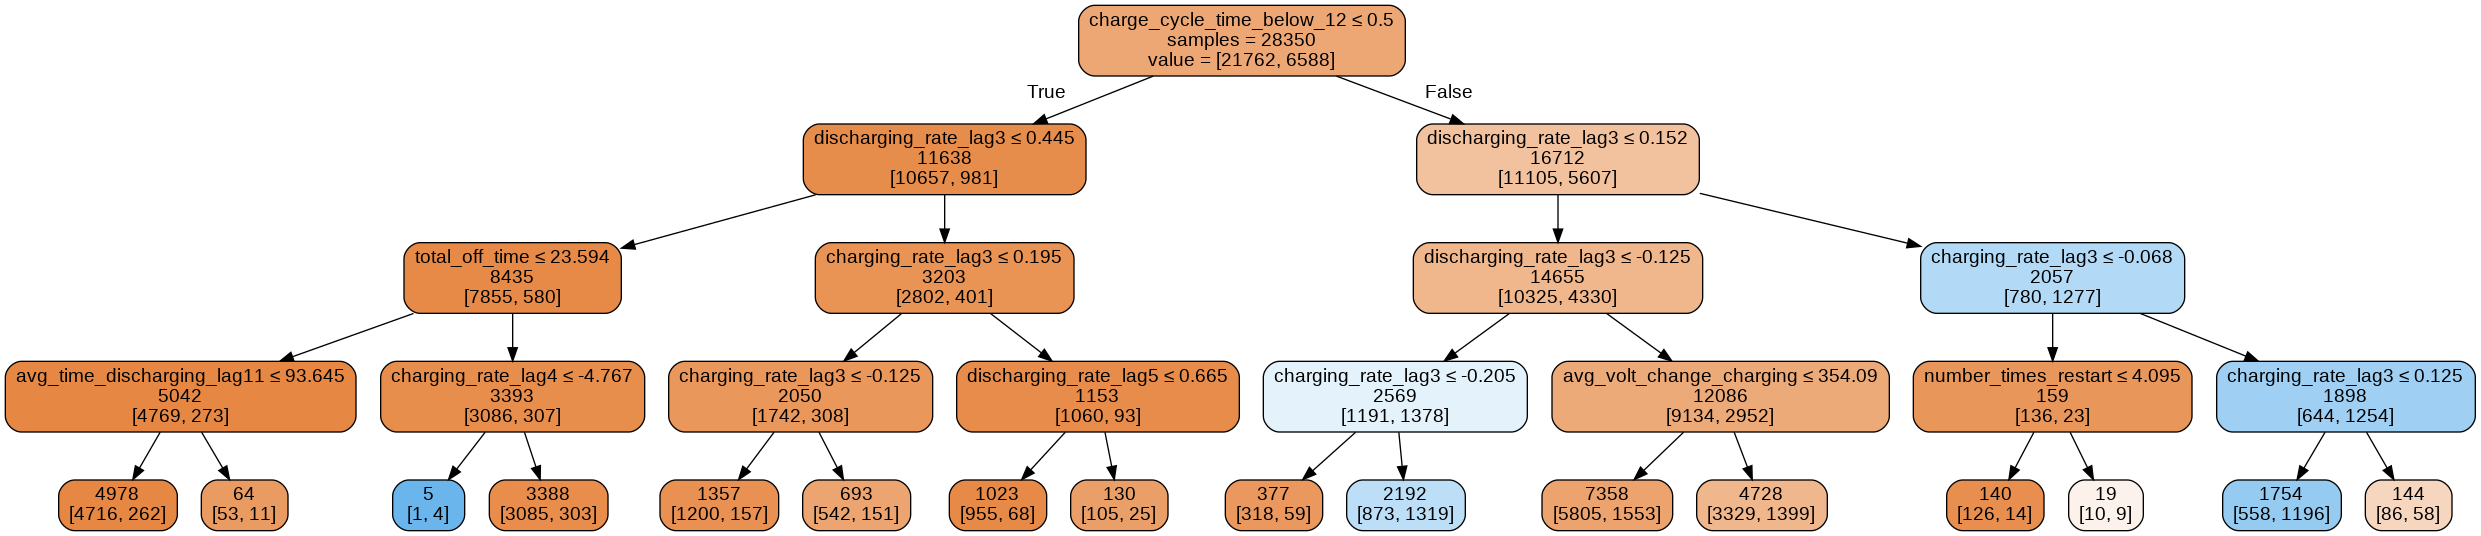

In [23]:
from sklearn.tree import DecisionTreeClassifier
from dmba import plotDecisionTree

DecisionTree = DecisionTreeClassifier(max_depth = 4)
DecisionTree.fit(train_X, train_y)

plotDecisionTree(DecisionTree, feature_names=train_X.columns)

### Feature Importance

In [24]:
importances = DecisionTree.feature_importances_

im = pd.DataFrame({'feature': train_X.columns, 'importance': importances})
im = im.sort_values('importance',ascending=False)
print(im)

                        feature  importance
12   charge_cycle_time_below_12    0.448823
10        discharging_rate_lag3    0.393047
4            charging_rate_lag3    0.126021
44     avg_volt_change_charging    0.021475
42               total_off_time    0.002776
37           charging_rate_lag4    0.002613
43         number_times_restart    0.002422
34        discharging_rate_lag5    0.001893
26   avg_time_discharging_lag11    0.000931
45  avg_volt_change_discharging    0.000000
46            avg_time_charging    0.000000
30   avg_time_discharging_lag13    0.000000
31      avg_time_charging_lag14    0.000000
32   avg_time_discharging_lag14    0.000000
33        discharging_rate_lag4    0.000000
50                   cycle_time    0.000000
35        discharging_rate_lag6    0.000000
36        discharging_rate_lag8    0.000000
49                   piececount    0.000000
38           charging_rate_lag5    0.000000
39           charging_rate_lag6    0.000000
40                 chargecycles 

### Model Metrics

In [25]:
dt_prediction_train = DecisionTree.predict(train_X) 
dt_prediction_valid = DecisionTree.predict(valid_X) 
    
print("Accuracy score on train is:",accuracy_score(train_y,dt_prediction_train))
print("Accuracy score on test is:",accuracy_score(valid_y,dt_prediction_valid))
print("Precision score on train is:",precision_score(train_y,dt_prediction_train))
print("Precision score on test is:",precision_score(valid_y,dt_prediction_valid))
print("Recall score on train is:",recall_score(train_y,dt_prediction_train))
print("Recall score on test is:",recall_score(valid_y,dt_prediction_valid))
print("F1 score on train is:",f1_score(train_y,dt_prediction_train))
print("F1 score on test is:",f1_score(valid_y,dt_prediction_valid))

Accuracy score on train is: 0.8059611992945326
Accuracy score on test is: 0.8052674897119342
Precision score on train is: 0.6375601113642116
Precision score on test is: 0.6310850439882698
Recall score on train is: 0.3823618700667881
Recall score on test is: 0.3825097760398151
F1 score on train is: 0.478033969067274
F1 score on test is: 0.4763169544046038


Accuracy is higher than other metrics for the decision tree model. Recall is relatively low.

## Naive Bayes

In [26]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(train_X, train_y)

# predict probabilities
prediction_train = nb.predict_proba(train_X)
prediction_valid = nb.predict_proba(valid_X)

### Model Metrics

In [27]:
nb_prediction_train = nb.predict(train_X) 
nb_prediction_valid = nb.predict(valid_X)

print("Accuracy on train is:",accuracy_score(train_y,nb_prediction_train)) 
print("Accuracy on test is:",accuracy_score(valid_y,nb_prediction_valid)) 
print("Precision_score train is:",precision_score(train_y,nb_prediction_train)) 
print("Precision_score on test is:",precision_score(valid_y,nb_prediction_valid)) 
print("Recall_score on train is:",recall_score(train_y,nb_prediction_train)) 
print("Recall_score on test is:",recall_score(valid_y,nb_prediction_valid)) 
print("f1_score on train is:",f1_score(train_y,nb_prediction_train)) 
print("f1_score on test is:",f1_score(valid_y,nb_prediction_valid))

Accuracy on train is: 0.62
Accuracy on test is: 0.6149794238683127
Precision_score train is: 0.34651213966111644
Precision_score on test is: 0.3426160337552743
Recall_score on train is: 0.7170613236187007
Recall_score on test is: 0.7216494845360825
f1_score on train is: 0.4672370308095545
f1_score on test is: 0.46463721675440606


Recall is higher than other metrics for the naive bayes model. Precision is relatively low.

## Random Forest

In [28]:
rf = RandomForestClassifier(random_state=0)
cc_rf = rf.fit(train_X.values, train_y.values.ravel())

In [29]:
rf_prediction_train = cc_rf.predict(train_X)
rf_prediction_valid = cc_rf.predict(valid_X)

print("Accuracy on train is:",accuracy_score(train_y,rf_prediction_train))
print("Accuracy on test is:",accuracy_score(valid_y,rf_prediction_valid))
print("Precision_score train is:",precision_score(train_y,rf_prediction_train))
print("Precision_score on test is:",precision_score(valid_y,rf_prediction_valid))
print("Recall_score on train is:",recall_score(train_y,rf_prediction_train))
print("Recall_score on test is:",recall_score(valid_y,rf_prediction_valid))
print("f1_score on train is:",f1_score(train_y,rf_prediction_train))
print("f1_score on test is:",f1_score(valid_y,rf_prediction_valid))

Accuracy on train is: 1.0
Accuracy on test is: 0.7978600823045268
Precision_score train is: 1.0
Precision_score on test is: 0.7035347776510832
Recall_score on train is: 1.0
Recall_score on test is: 0.21933878421613937
f1_score on train is: 1.0
f1_score on test is: 0.3344173441734417


There's an overfitting problem in this model since all scores from training set, which are close to 100%, are much higher than ones from test set.

## Gradient Boosted Trees

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(random_state=0)
gbm.fit(train_X, train_y)
gbm.predict(valid_X[:2])

array([0, 0])

### Feature Importance

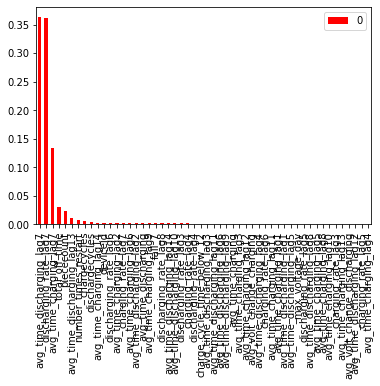

In [31]:
importances = list(zip(gbm.feature_importances_, tr.columns))
pd.DataFrame(importances, index=[x for (_,x) in importances]).sort_values(by = 0, ascending = False).plot(kind = 'bar', color = 'r')

Most important feature is discharging_rate_lag3

### Model Metrics

In [32]:
gbt_prediction_train = gbm.predict(train_X)
gbt_prediction_valid = gbm.predict(valid_X)

print("Accuracy on train is:",accuracy_score(train_y,gbt_prediction_train))
print("Accuracy on test is:",accuracy_score(valid_y,gbt_prediction_valid))
print("Precision_score train is:",precision_score(train_y,gbt_prediction_train))
print("Precision_score on test is:",precision_score(valid_y,gbt_prediction_valid))
print("Recall_score on train is:",recall_score(train_y,gbt_prediction_train))
print("Recall_score on test is:",recall_score(valid_y,gbt_prediction_valid))
print("f1_score on train is:",f1_score(train_y,gbt_prediction_train))
print("f1_score on test is:",f1_score(valid_y,gbt_prediction_valid))

Accuracy on train is: 0.8185537918871252
Accuracy on test is: 0.8137448559670782
Precision_score train is: 0.7053469852104665
Precision_score on test is: 0.6816380449141347
Recall_score on train is: 0.37644201578627806
Recall_score on test is: 0.3668681123355848
f1_score on train is: 0.49089469517022954
f1_score on test is: 0.4770048532470534


Accuracy is higher than other metrics for the gradient boosted tree model. Recall is relatively low.

# Neural Network

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scale=scaler.fit_transform(X)
X_scale.shape

(40500, 52)

In [34]:
y_tr = tr[[outcome]] # for neural network only because this model need to get y_df.shape[1]
train_X_nn, valid_X_nn, train_y_nn, valid_y_nn = train_test_split(X_scale, y_tr, test_size=0.3, random_state=1) 

In [35]:
import tensorflow as tf
from tensorflow import keras

In [36]:
model2 = tf.keras.Sequential([ tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
                             tf.keras.layers.Dense(units=1,activation=tf.nn.sigmoid)])

In [37]:
model2.compile(optimizer= tf.optimizers.Adam(),
              loss = tf.losses.binary_crossentropy,
              metrics = ['accuracy'])

In [38]:
model2.fit(train_X_nn, train_y_nn, epochs = 15)

Epoch 1/15
886/886 [==============================] - 5s 2ms/step - loss: 0.5204 - accuracy: 0.7626
Epoch 2/15
886/886 [==============================] - 2s 2ms/step - loss: 0.4932 - accuracy: 0.7623
Epoch 3/15
886/886 [==============================] - 2s 2ms/step - loss: 0.4903 - accuracy: 0.7646
Epoch 4/15
886/886 [==============================] - 2s 2ms/step - loss: 0.4877 - accuracy: 0.7692
Epoch 5/15
886/886 [==============================] - 2s 2ms/step - loss: 0.4918 - accuracy: 0.7644
Epoch 6/15
886/886 [==============================] - 2s 2ms/step - loss: 0.4909 - accuracy: 0.7647
Epoch 7/15
886/886 [==============================] - 2s 2ms/step - loss: 0.4857 - accuracy: 0.7662
Epoch 8/15
886/886 [==============================] - 2s 2ms/step - loss: 0.4865 - accuracy: 0.7666
Epoch 9/15
886/886 [==============================] - 2s 2ms/step - loss: 0.4848 - accuracy: 0.7693
Epoch 10/15
886/886 [==============================] - 2s 2ms/step - loss: 0.4862 - accuracy: 0.7697

In [39]:
model2.evaluate(valid_X_nn, valid_y_nn)

380/380 [==============================] - 1s 1ms/step - loss: 0.4937 - accuracy: 0.7649


[0.4937037527561188, 0.7649382948875427]

In [40]:
y_pred_valid = model2.predict(valid_X_nn).ravel()
y_pred = model2.predict(train_X_nn).ravel()

# Model Metrics

In [41]:
# predict probabilities for test set
prediction_probs = model2.predict(valid_X_nn)
# predict classes
nn_prediction_train = (model2.predict(train_X_nn) > 0.5).astype("int32")
nn_prediction_valid = (model2.predict(valid_X_nn) > 0.5).astype("int32")

print("Accuracy on train is:",accuracy_score(train_y_nn,nn_prediction_train))
print("Accuracy on test is:",accuracy_score(valid_y_nn,nn_prediction_valid))
print("Precision_score train is:",precision_score(train_y_nn,nn_prediction_train))
print("Precision_score on test is:",precision_score(valid_y_nn,nn_prediction_valid))
print("Recall_score on train is:",recall_score(train_y_nn,nn_prediction_train))
print("Recall_score on test is:",recall_score(valid_y_nn,nn_prediction_valid))
print("f1_score on train is:",f1_score(train_y_nn,nn_prediction_train))
print("f1_score on test is:",f1_score(valid_y_nn,nn_prediction_valid))

Accuracy on train is: 0.7699470899470899
Accuracy on test is: 0.7649382716049383
Precision_score train is: 0.5332661290322581
Precision_score on test is: 0.45295404814004375
Recall_score on train is: 0.08029751062537947
Recall_score on test is: 0.07358691788126555
f1_score on train is: 0.13957783641160948
f1_score on test is: 0.12660550458715597


## Baseline AUC

In [42]:
from sklearn.metrics import roc_curve, auc
# LR
fpr, tpr, thresholds = roc_curve(train_y,lr_prediction_train)
print("LogisticRegression Train: ",str(auc(fpr, tpr)))
fpr, tpr, thresholds = roc_curve(valid_y,lr_prediction_valid)
print("LogisticRegression Valid: ",str(auc(fpr, tpr)),"\n")
# DT
fpr, tpr, thresholds = roc_curve(train_y,dt_prediction_train)
print("DecisionTree Train: ",str(auc(fpr, tpr)))
fpr, tpr, thresholds = roc_curve(valid_y,dt_prediction_valid)
print("DecisionTree Valid: ",str(auc(fpr, tpr)),"\n")
# NB
fpr, tpr, thresholds = roc_curve(train_y,nb_prediction_train)
print("NaiveBayes Train: ",str(auc(fpr, tpr)))
fpr, tpr, thresholds = roc_curve(valid_y,nb_prediction_valid)
print("NaiveBayes Valid: ",str(auc(fpr, tpr)),"\n")
# RF
fpr, tpr, thresholds = roc_curve(train_y,rf_prediction_train)
print("RandomForest Train: ",str(auc(fpr, tpr)))
fpr, tpr, thresholds = roc_curve(valid_y,rf_prediction_valid)
print("RandomForest Valid: ",str(auc(fpr, tpr)),"\n")
# GBT
fpr, tpr, thresholds = roc_curve(train_y,gbt_prediction_train )
print("GradientBoostedTree Train: ",str(auc(fpr, tpr)))
fpr, tpr, thresholds = roc_curve(valid_y,gbt_prediction_valid)
print("GradientBoostedTree Valid: ",str(auc(fpr, tpr)),"\n")
# NN
fpr, tpr, thresholds = roc_curve(train_y_nn, y_pred)
print("NeuralNetworks Train: ",str(auc(fpr, tpr)))
#fpr, tpr, thresholds = roc_curve(valid_y,nn_prediction_valid)
fpr, tpr, thresholds = roc_curve(valid_y_nn, y_pred_valid)
print("NeuralNetworkss Valid: ",str(auc(fpr, tpr)),"\n")



LogisticRegression Train:  0.679651023516703
LogisticRegression Valid:  0.6745524011610746 

DecisionTree Train:  0.6582795472932965
DecisionTree Valid:  0.6575716921325775 

NaiveBayes Train:  0.6538389974402666
NaiveBayes Valid:  0.6522459696430011 

RandomForest Train:  1.0
RandomForest Valid:  0.5957462904694277 

GradientBoostedTree Train:  0.6644180486063087
GradientBoostedTree Valid:  0.657622767745387 

NeuralNetworks Train:  0.7278168890007128
NeuralNetworkss Valid:  0.7115014474977157 



In [43]:
## ROC Curve Analysis

In [44]:
rf_proba = cc_rf.predict_proba(valid_X)[:,1]
rf_roc = roc_curve(valid_y, rf_proba)
rf_roc = pd.DataFrame(rf_roc)
gbm_proba=gbm.predict_proba(valid_X)[:,1]
gbm_roc = roc_curve(valid_y, gbm_proba)
gbm_roc = pd.DataFrame(gbm_roc)
nn_proba = model2.predict(valid_X_nn)
nn_roc = roc_curve(valid_y_nn, nn_proba)
nn_roc = pd.DataFrame(nn_roc)

                                                                                                  fpr  ...       auc
classifiers                                                                                            ...          
LogisticRegression(C=1e+42, class_weight='balan...  [0.0, 0.0001071007818357074, 0.000428403127342...  ...  0.717728
GaussianNB(priors=None, var_smoothing=1e-09)        [0.0, 0.0, 0.0, 0.0012852093820284888, 0.00128...  ...  0.679613
DecisionTreeClassifier(ccp_alpha=0.0, class_wei...  [0.0, 0.0002142015636714148, 0.027417800149941...  ...  0.756570

[3 rows x 3 columns]


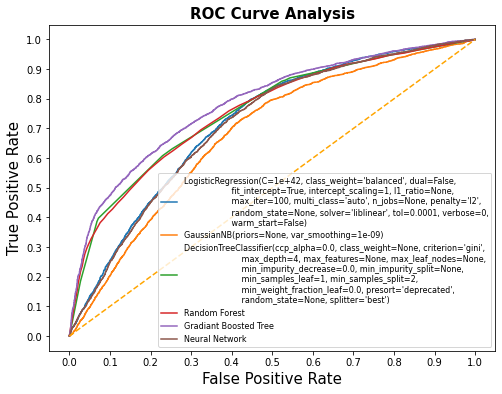

In [45]:
import sklearn.metrics as metrics
from sklearn.metrics import plot_roc_curve
%matplotlib inline
Classifier = [logit_reg,nb,DecisionTree]
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
for cls in Classifier:
    yproba = cls.predict_proba(valid_X)[:,1]
    #plot_roc_curve(cls, valid_X, valid_y)
    fpr, tpr, thresholds = roc_curve(valid_y,  yproba)

    auc = roc_auc_score(valid_y, yproba)
    
    result_table = result_table.append({'classifiers':cls,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
result_table.set_index('classifiers', inplace=True)
#result_table.fillna(0)
fig = plt.figure(figsize=(8,6))

print(result_table.head())

for i in result_table.index:

    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'],
             label=i)
             #label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot(rf_roc.loc[0,:], rf_roc.loc[1,:], label="Random Forest")
plt.plot(gbm_roc.loc[0,:], gbm_roc.loc[1,:], label="Gradiant Boosted Tree")
plt.plot(nn_roc.loc[0,:], nn_roc.loc[1,:], label="Neural Network")

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':8}, loc='lower right')

plt.show()

Gradient boosted tree and decision tree performed best. Random forest has overfitting. 